In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json('data/Brisbane_CityBike.json')
print("Dataset shape ", data.shape)
data.head()

Dataset shape  (149, 5)


,address,latitude,longitude,name,number
0,Lower River Tce / Ellis St,-27.482279,153.028723,122 - LOWER RIVER TCE / ELLIS ST,122
1,Main St / Darragh St,-27.470590,153.036046,91 - MAIN ST / DARRAGH ST,91
2,Sydney St Ferry Terminal / Park,-27.474531,153.042728,88 - SYDNEY ST FERRY TERMINAL / PARK,88
3,Browne St / James St,-27.461881,153.046986,75 - BROWNE ST / JAMES ST,75
4,Kurilpa Point / Montague Rd,-27.469658,153.016696,98 - KURILPA POINT / MONTAGUE RD,98


In [3]:
#def transform(s):
#    tokens = s.split('-', 1)
#    if(len(tokens)>1):
#        return tokens[1].strip()
#    return None
#
#data['corner_1'], data['corner_2'] = data['name'].str.split('/', 1).str
#
#data['corner_1'] = data['corner_1'].apply( lambda x: transform(x))
#
#data['corner_2'] = data['corner_2'].str.strip()
#
#data.head()

## HDBSCAN clustering on coordinates

We standardize data in the way that latitude and longitude have the same weight.
Moreover we analyze results on HDBSCAN based on two differents configuration:

- HDBSCAN with haversine similarity on standardized radiants points;
- HDBSCAN with euclidean similarity on standardized latitude and longitude data. Using euclidean distance on this dataset is not a problem since points are related to the same city. 


### Calculate the best value for min_cluster_size parameter

For identify the best value of the input parameter *min_cluster_size* we use the silhouette coefficient. The silhouette calculate the separation distance between the resulting clusters. In particular, it measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

This measure has a range of **[-1, 1]**. Silhouette coefficients near *+1* indicate that the sample is far away from the neighboring clusters (i.e.  best score). A value of *0* indicates that the sample is on or very close to the decision boundary between two neighboring clusters (i.e. 0 suggests overlapping clusters) and *negative values* indicate that those samples might have been assigned to the wrong cluster.

Since we are including in the silhouette analysis the cluster *-1* (i.e. *noise* cluster), we are preferring clustering configurations that generate a small set of noisy points.  

<p>
<img src="imgs/hdbscan_haversine.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<em>Clustering based on HDBSCAN using haversine similarity on standardized radiants points. Black points is noise.</em>
    
</p>    

<p>
<img src="imgs/hdbscan_euclidean.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<em>Clustering based on HDBSCAN using euclidean similarity on standardized points. Black points is noise.</em>
    
</p> 

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import hdbscan
from sklearn.cluster import KMeans

def analize_parameter( set_parameter, data, algorithm = "HDBSCAN_HAVERSINE"):
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    # more details in http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


    for parameter in set_parameter:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (parameter + 1) * 10])

        if(algorithm == "HDBSCAN_HAVERSINE"):
            clusterer = hdbscan.HDBSCAN(min_cluster_size=parameter, metric='haversine')
            cluster_labels = clusterer.fit_predict(data)
        elif(algorithm == "HDBSCAN_EUCLIDEAN"):
            clusterer = hdbscan.HDBSCAN(min_cluster_size=parameter, metric='euclidean')
            cluster_labels = clusterer.fit_predict(data)
        elif(algorithm == "KMEANS"):
            kmeans = KMeans(n_clusters=parameter).fit(data)
            cluster_labels = kmeans.labels_
        else:
            print("Wrong value for parameter ALGORITHM")
            return

        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For value parameter =", parameter, "The average silhouette_score is :", silhouette_avg)
        #print("Extracted Clusters: ", len(set(cluster_labels)))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        n_clusters = len(set(cluster_labels))


        y_lower = 10
        for i in set(cluster_labels):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            #print("cluster "+ str(i) + " have size "+ str(size_cluster_i))

            color = cm.nipy_spectral(int(i+1) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        scaled_cluster_values = cluster_labels + 1

        colors = cm.nipy_spectral(scaled_cluster_values.astype(int) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='o', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

        # Labeling the clusters
        #centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

        #for i, c in enumerate(centers):
        #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")



        plt.suptitle("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d and input parameter = %d" % (algorithm, n_clusters, parameter),
                     fontsize=14, fontweight='bold')

        plt.show()

For value parameter = 3 The average silhouette_score is : 0.09802331383858508


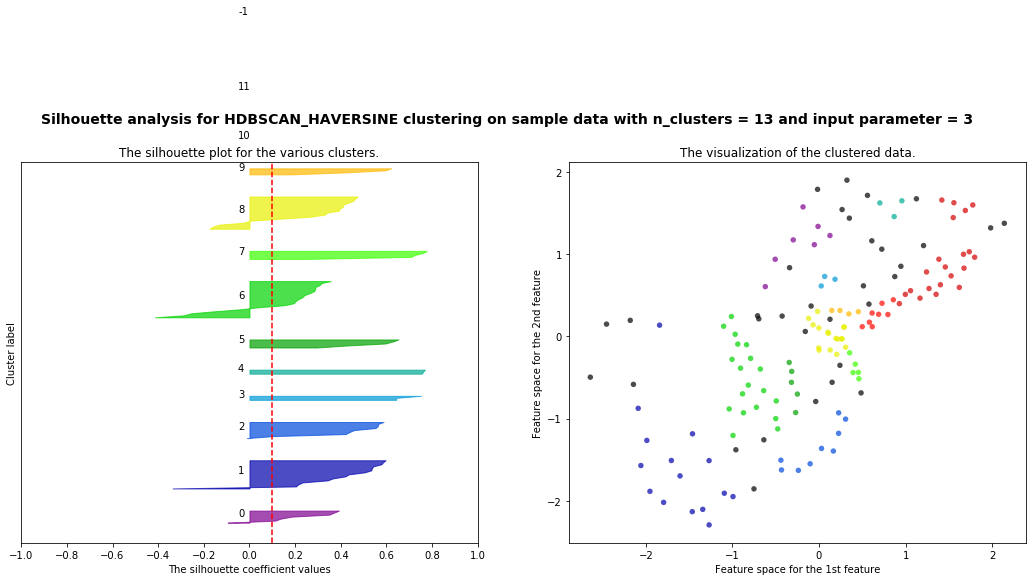

For value parameter = 4 The average silhouette_score is : 0.14060616253165756


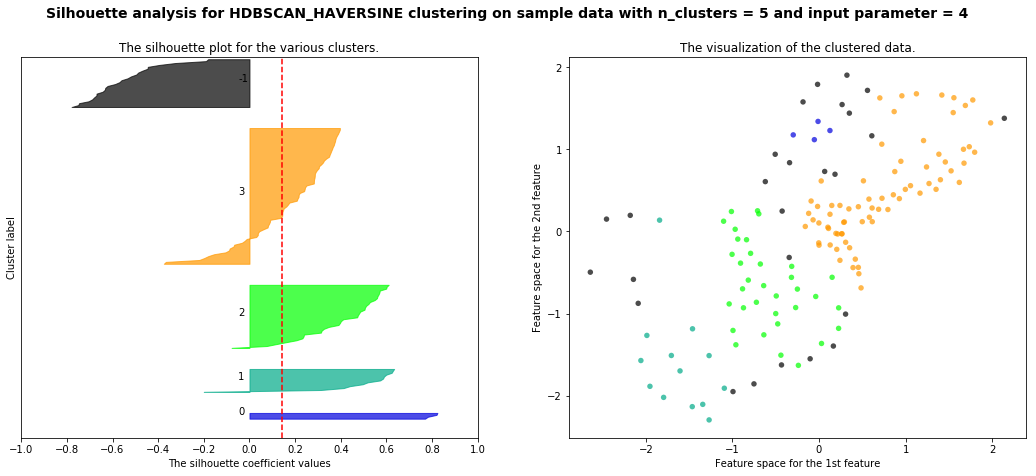

For value parameter = 5 The average silhouette_score is : 0.11083684328259902


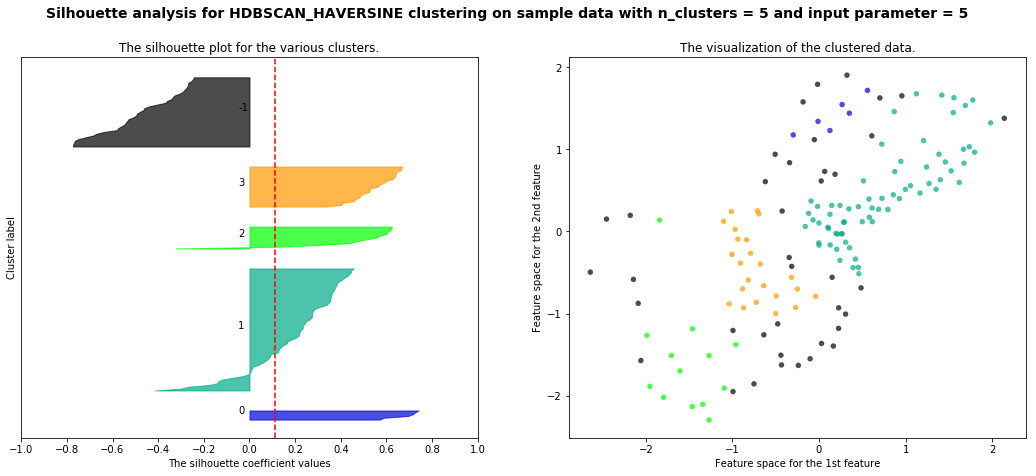

For value parameter = 6 The average silhouette_score is : 0.1610135644830978


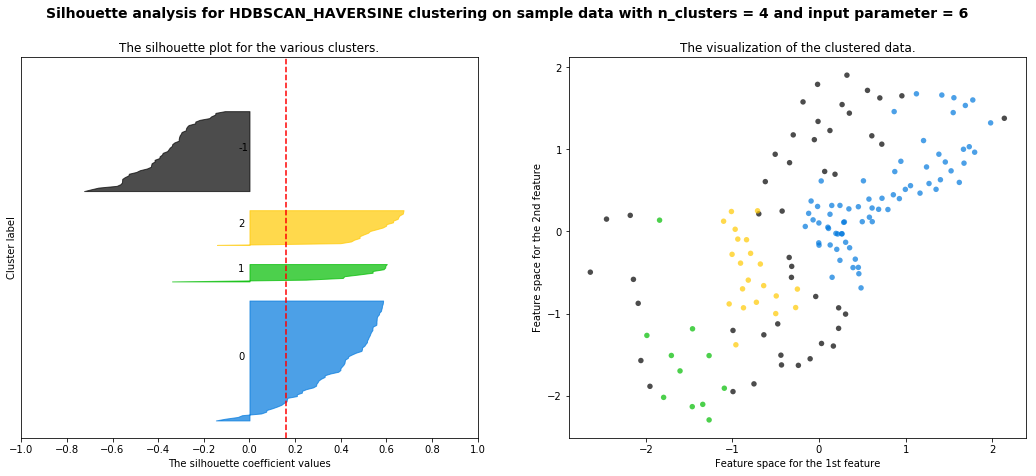

For value parameter = 7 The average silhouette_score is : 0.23411860199182677


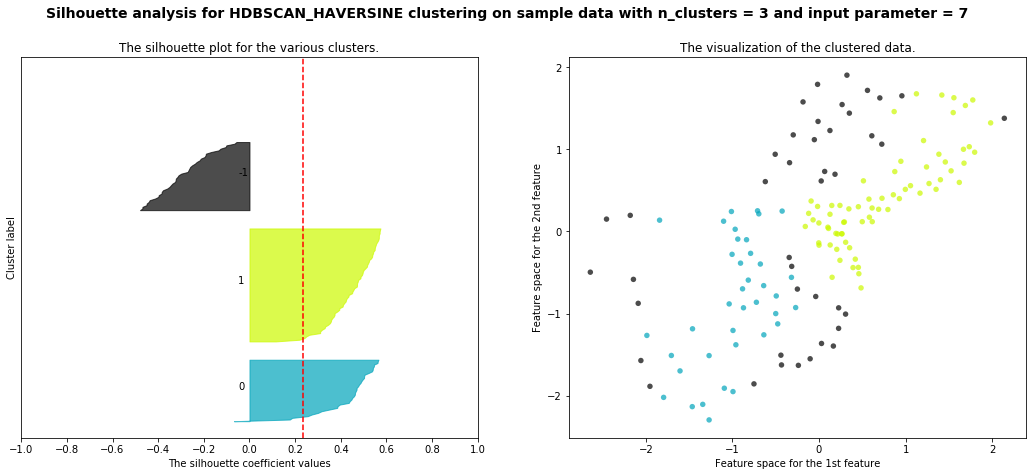

For value parameter = 8 The average silhouette_score is : 0.19481667682039067


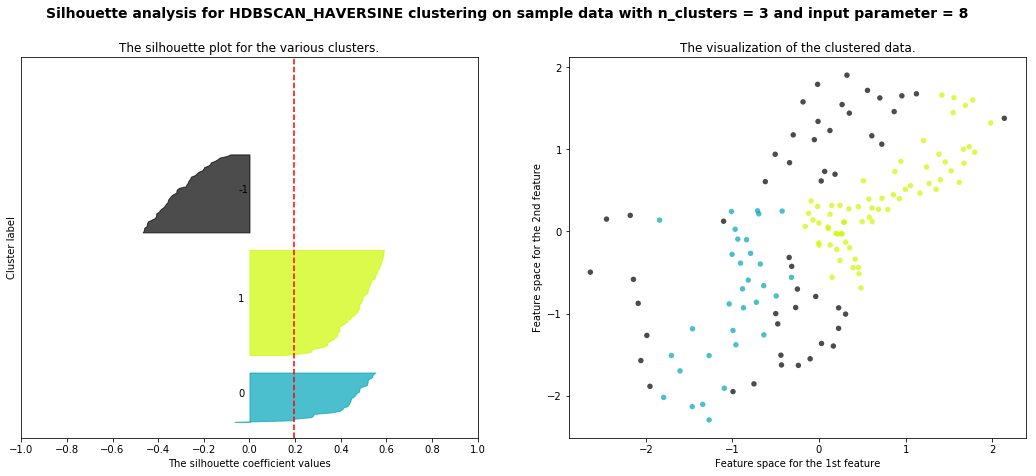

In [5]:
points = list(zip(data.latitude, data.longitude))
rads = np.radians(points)

#standardization
from sklearn import preprocessing
scaled_rads = preprocessing.scale(rads)
analize_parameter([3, 4, 5, 6, 7, 8], scaled_rads)


For value parameter = 3 The average silhouette_score is : 0.0784260419289944


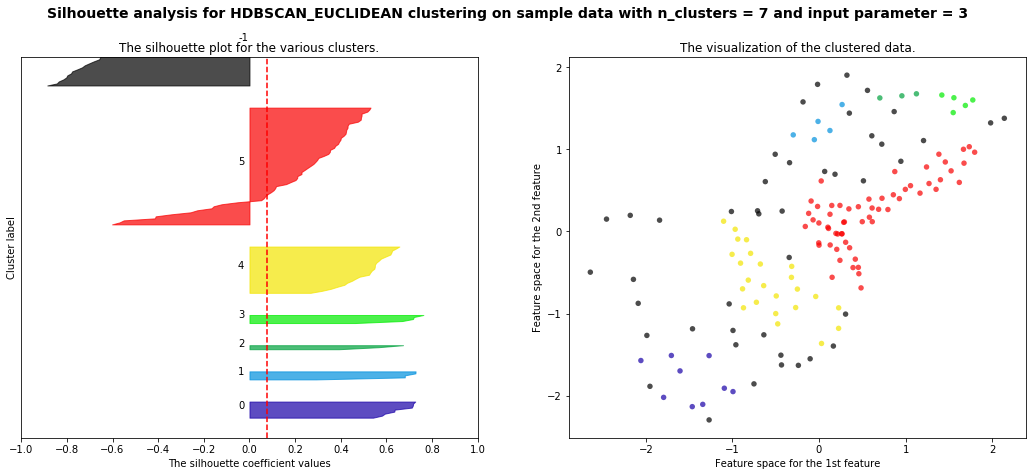

For value parameter = 4 The average silhouette_score is : 0.03718917433360647


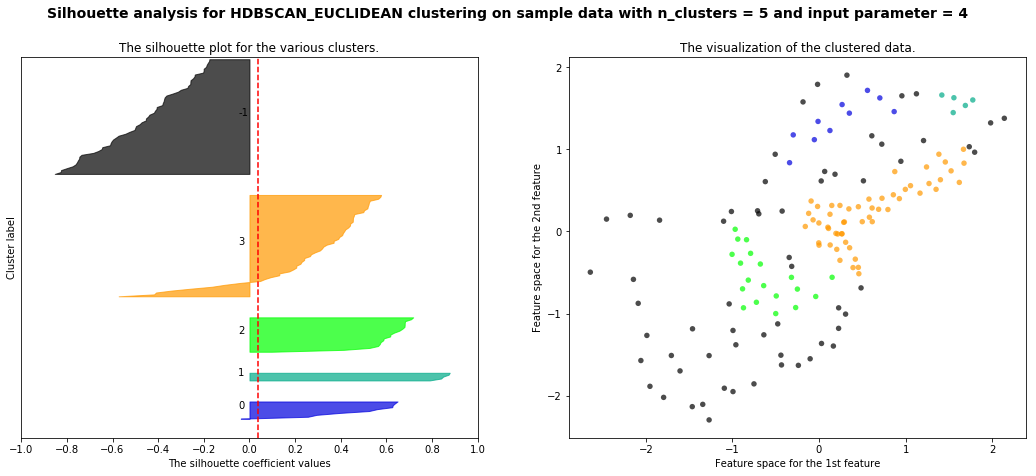

For value parameter = 5 The average silhouette_score is : 0.041438317057659185


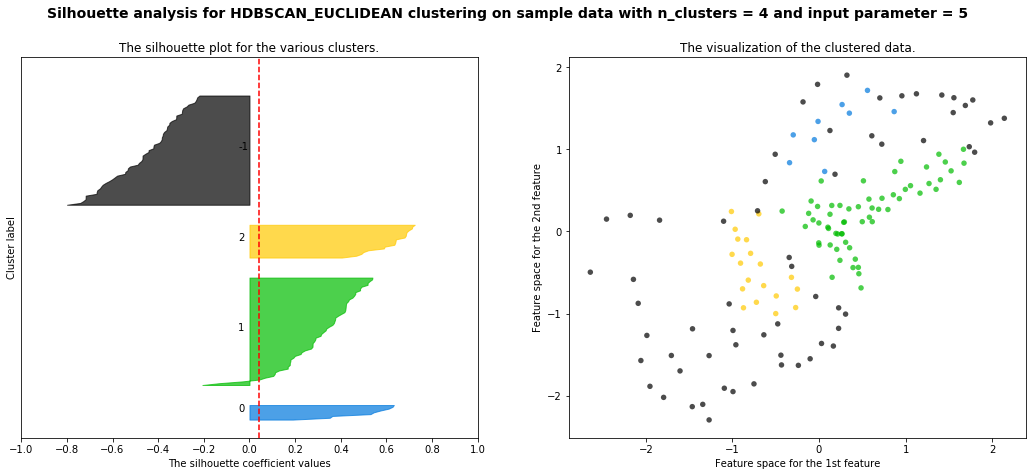

For value parameter = 6 The average silhouette_score is : 0.00600040941107911


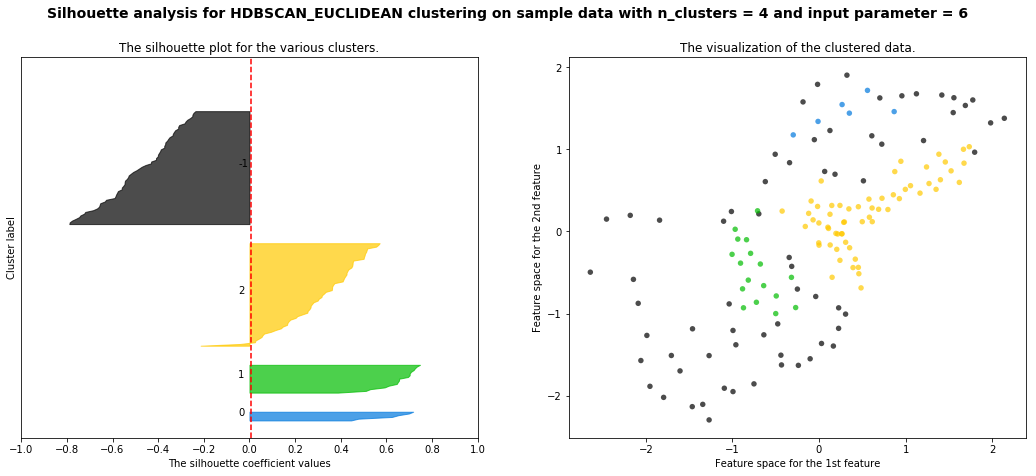

For value parameter = 7 The average silhouette_score is : 0.05524801730663048


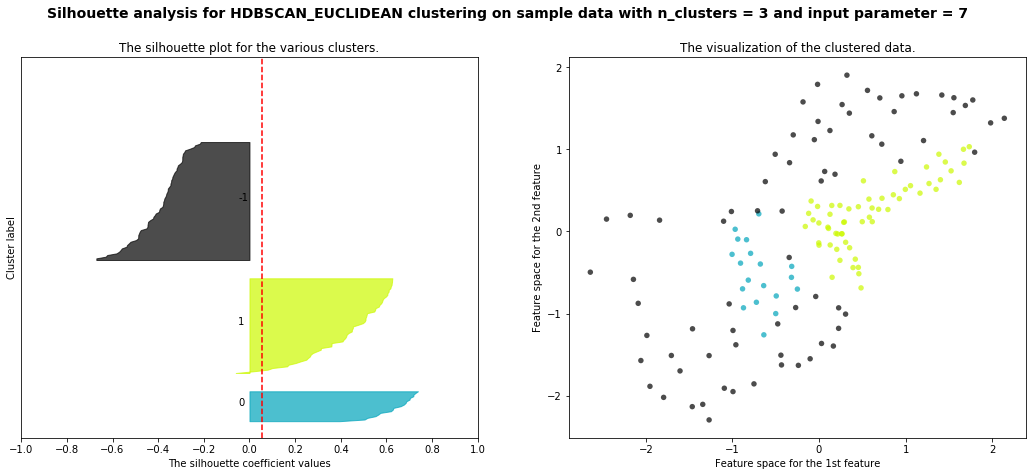

For value parameter = 8 The average silhouette_score is : 0.0070333994953361584


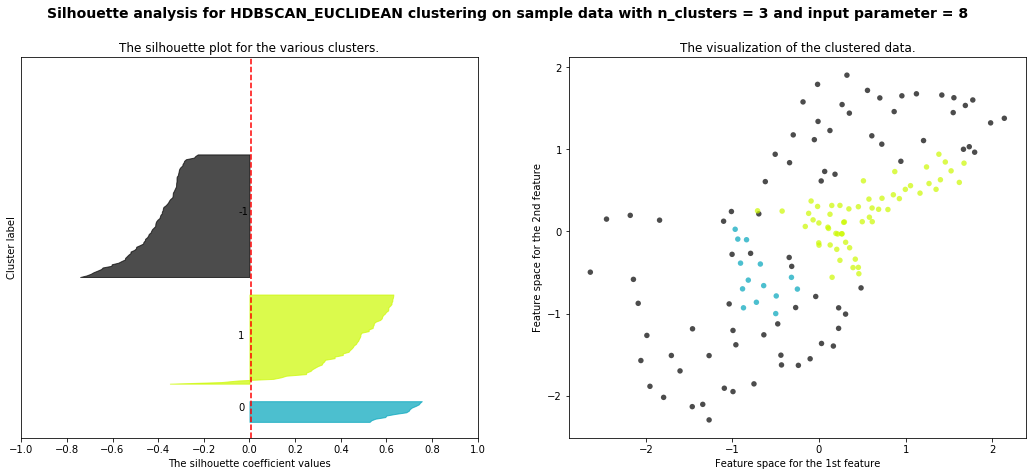

In [6]:
from sklearn import preprocessing

points = list(zip(data.latitude, data.longitude))

#standardization
scaled_points = preprocessing.scale(points)
analize_parameter([3, 4, 5, 6, 7, 8], scaled_points, algorithm = "HDBSCAN_EUCLIDEAN")

In [7]:
#Apply haversine distance on RADIANS
#http://hdbscan.readthedocs.io/en/latest/faq.html?highlight=lat%20lon%27#q-haversine-metric-is-not-clustering-my-lat-lon-data-correctly
import hdbscan
points = list(zip(data.latitude, data.longitude))
rads = np.radians(points)

#standardization
from sklearn import preprocessing
scaled_rads = preprocessing.scale(rads)

clusterer = hdbscan.HDBSCAN(min_cluster_size=4, metric='haversine')
cluster_label_haversines = clusterer.fit_predict(scaled_rads)
print("Extracted Clusters: ", len(set(cluster_label_haversines)))

Extracted Clusters:  5


In [8]:
#Apply euclidean distance on original data
import hdbscan
points = list(zip(data.latitude, data.longitude))

#standardization
from sklearn import preprocessing
scaled_points = preprocessing.scale(points)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
cluster_labels_euclidean = clusterer.fit_predict(scaled_points)
print("Extracted Clusters: ", len(set(cluster_labels_euclidean)))

Extracted Clusters:  7


## Clustering based on K-Means

<img src="imgs/kmeans.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />


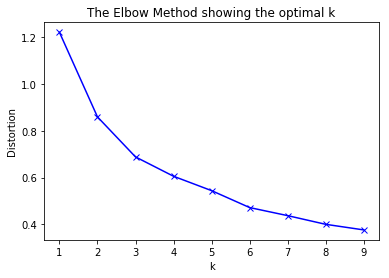

In [9]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing


points = list(zip(data.latitude, data.longitude))

#standardization
scaled_points = preprocessing.scale(points)


# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_points)
    kmeanModel.fit(scaled_points)
    distortions.append(sum(np.min(cdist(scaled_points, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(scaled_points))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


For value parameter = 2 The average silhouette_score is : 0.46668756470757505


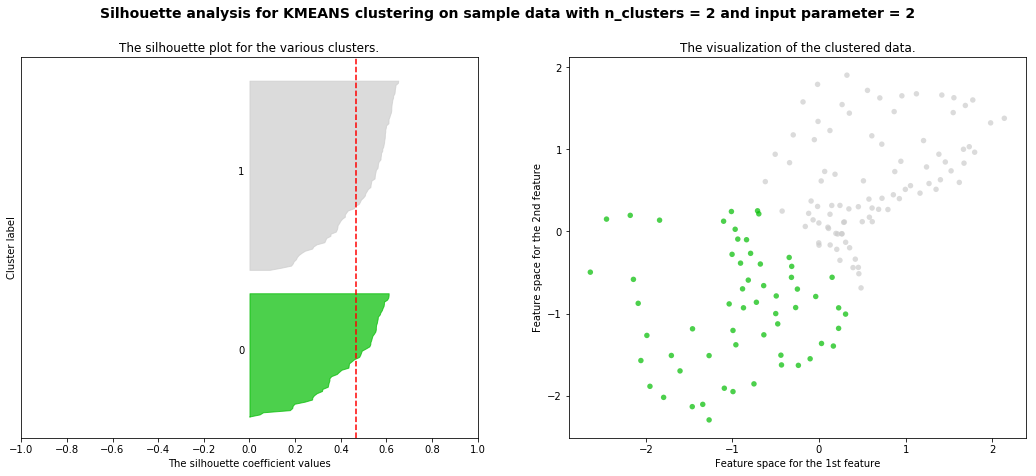

For value parameter = 3 The average silhouette_score is : 0.3924365242112104


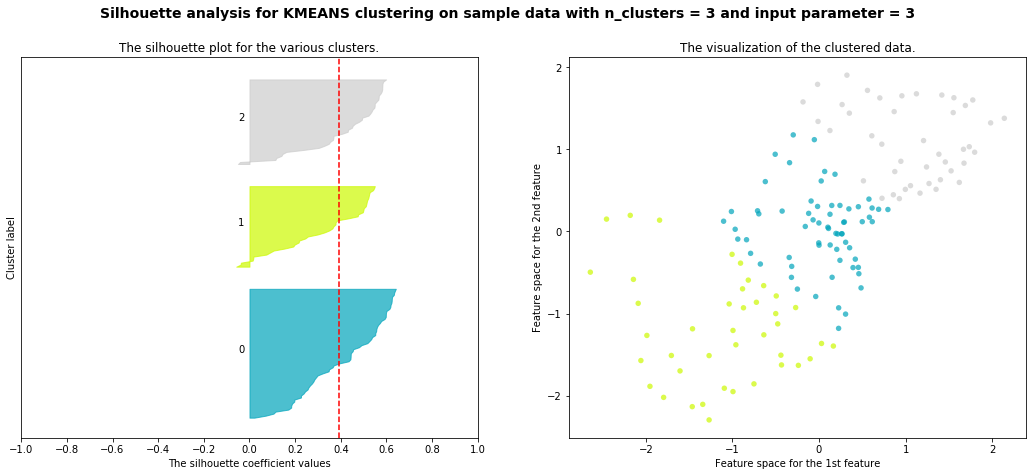

For value parameter = 4 The average silhouette_score is : 0.374154523182854


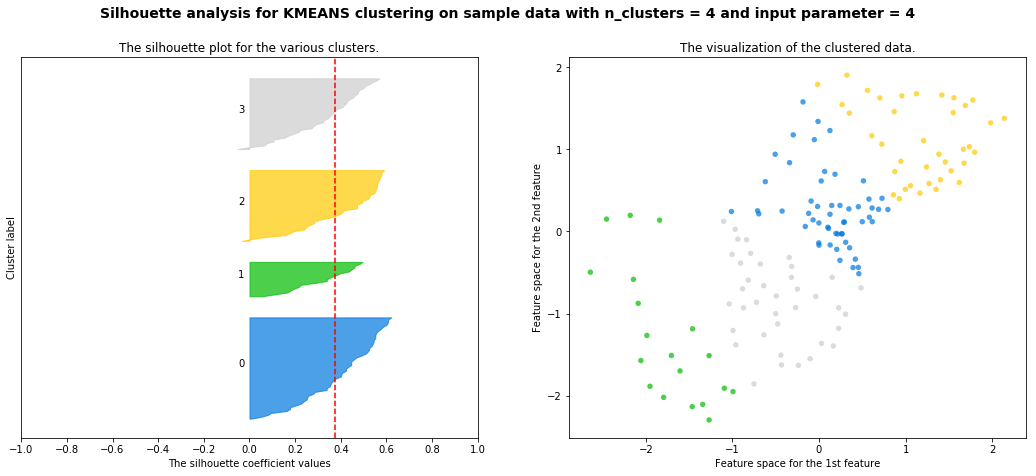

For value parameter = 5 The average silhouette_score is : 0.4058596996435337


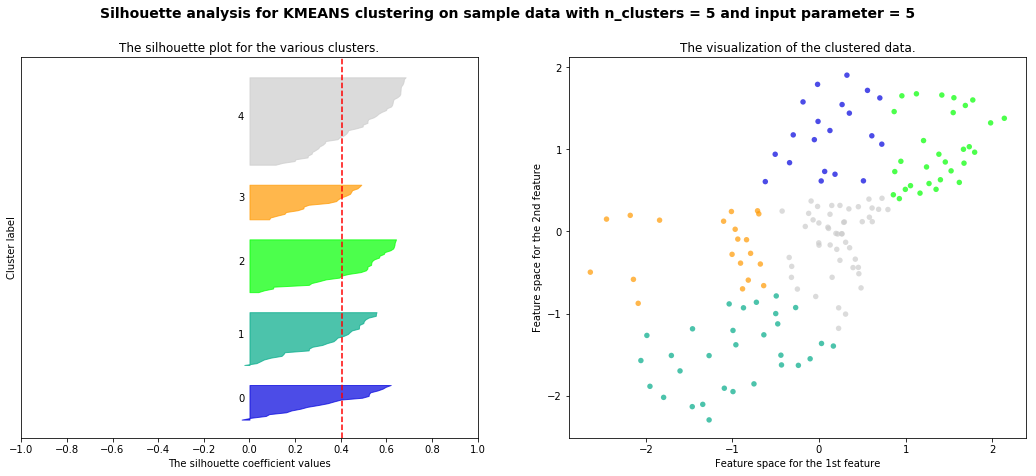

For value parameter = 6 The average silhouette_score is : 0.4126328654424615


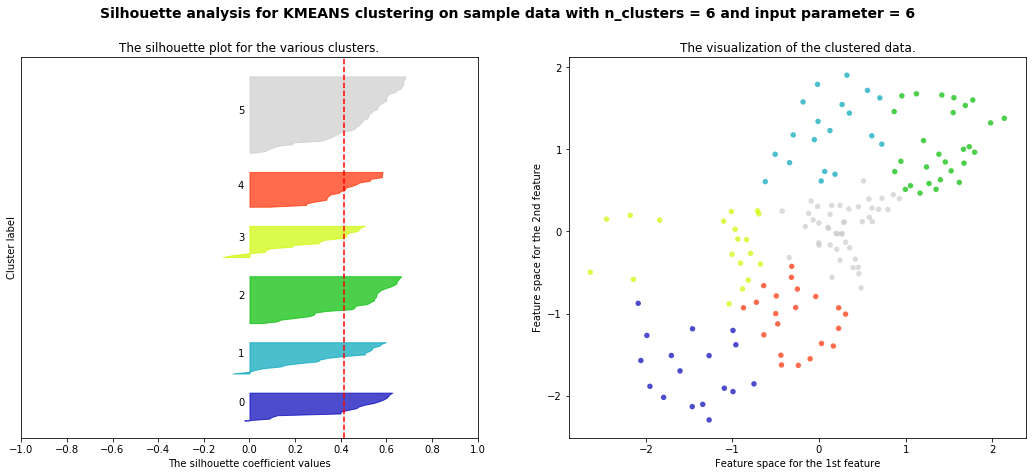

For value parameter = 7 The average silhouette_score is : 0.4321224938877514


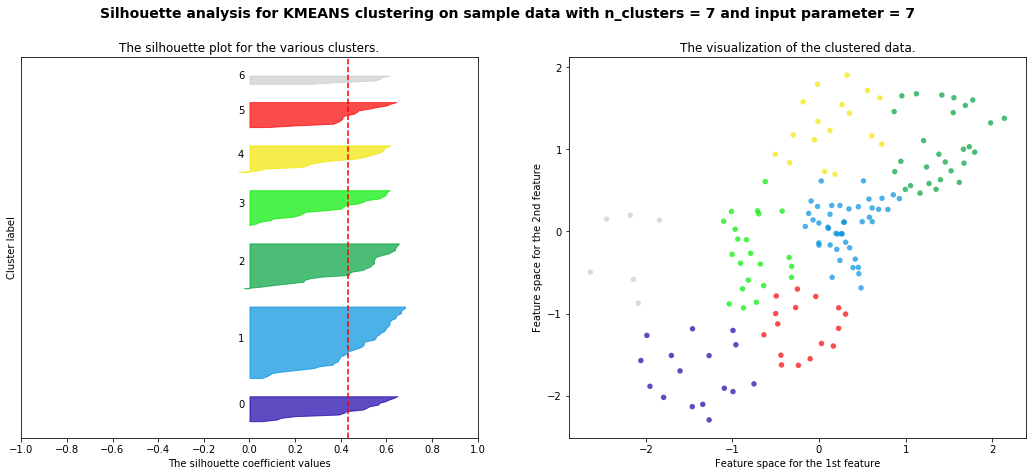

For value parameter = 8 The average silhouette_score is : 0.39994368349528137


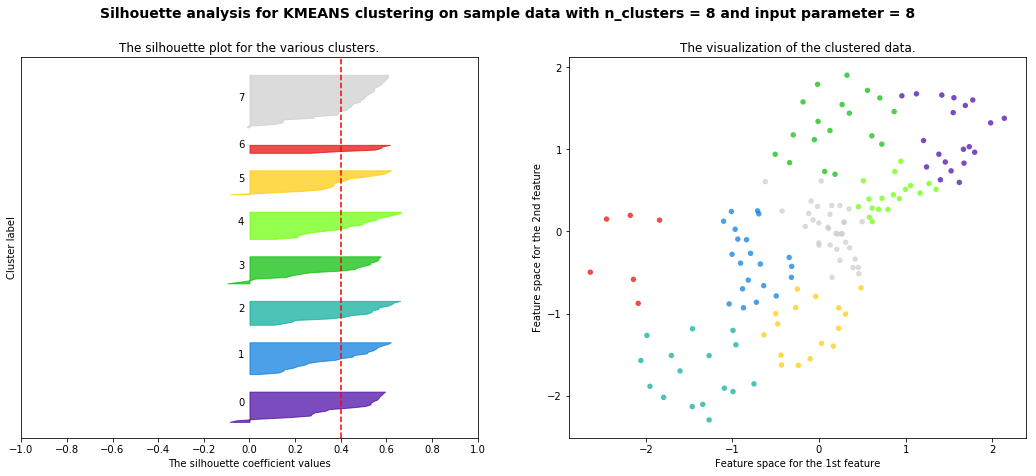

In [10]:
from sklearn import preprocessing

points = list(zip(data.latitude, data.longitude))

#standardization
scaled_points = preprocessing.scale(points)
analize_parameter([2, 3, 4, 5, 6, 7, 8], scaled_points, algorithm = "KMEANS")

In [20]:
kmeans = KMeans(n_clusters=3).fit(scaled_points)
cluster_labels_kmeans = kmeans.labels_

## Data Visualization

In [21]:
c_lat =  data["latitude"].mean()
c_lon = data["longitude"].mean()

#cluster_labels = cluster_label_haversines
#cluster_labels = cluster_labels_euclidean
cluster_labels = cluster_labels_kmeans

In [22]:
# color palette from ColorBrewer2: http://colorbrewer2.org/
palette = ['#a6cee3','#1f78b4','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99', '#b2df8a']

classes = range(-1, len(palette) -1)
colors = dict(zip(classes, palette))

c_array = [colors[x]for x in cluster_labels]

from gmplot import gmplot
gmap = gmplot.GoogleMapPlotter(c_lat, c_lon, 14)
for c in classes:
    index = [i for i,v in enumerate(cluster_labels) if cluster_labels[i]==c]
    subset = data.iloc[index]
    if(c==-1):
        color = "#000000"
    else:
        color = colors[c]
    gmap.scatter(subset["latitude"], subset["longitude"], c = color, size=60, marker=False, face_color= "#FF0000", face_alpha= 1)
    gmap.draw("my_map2.html")

#open the html page with a browser    

In [23]:
gmap.heatmap(data["latitude"], data["longitude"], radius=50)
gmap.draw("my_map3.html")

In [15]:

#filename = "my_map3"
#
#from selenium import webdriver    
#from xvfbwrapper import Xvfb
#d=Xvfb(width=400,height=400)
#d.start()
#browser=webdriver.Firefox()
#url=filename+ ".html"
#browser.get(url)
#destination=filename +".jpg"
#if browser.save_screenshot(destination):
#    print("File saved in the destination filename")
#browser.quit()